<a href="https://colab.research.google.com/github/Ashwin1999/COVID-19-Data-Mining/blob/nivethsaran/COVID_19_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import warnings
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import datetime
import matplotlib
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')



matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


import dataset from this link: https://github.com/Ashwin1999/COVID-19-Data-Mining

# India Covid Data


In [ ]:
files = [
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/complete.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/district_level_latest.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/nation_level_daily.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/patients_data.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/state_level_daily.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/state_level_latest.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_day_wise.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_state_wise.csv',
]

In [2]:
indiadaily=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/nation_level_daily.csv')
indiadaily['Date'] = indiadaily['Date'].str.slice(0,6) +' 2020'
indiadaily['Date']= indiadaily['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d %b %Y'))
indiadaily['Date']= pd.to_datetime(indiadaily['Date'])
print(indiadaily.dtypes)
indiadaily.tail()

Date               datetime64[ns]
Daily Confirmed             int64
Total Confirmed             int64
Daily Recovered             int64
Total Recovered             int64
Daily Deceased              int64
Total Deceased              int64
dtype: object


,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
185,2020-08-02,52672,1804857,40355,1187261,760,38180
186,2020-08-03,50488,1855345,43070,1230331,806,38986
187,2020-08-04,51282,1906627,51220,1281551,849,39835
188,2020-08-05,56626,1963253,45583,1327134,919,40754
189,2020-08-06,62170,2025423,50141,1377275,899,41653


In [3]:
complete = pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/complete.csv')
complete['Date']= pd.to_datetime(complete['Date'])
complete.rename(columns={'Name of State / UT':'State'},inplace=True)
complete['Death'] = complete['Death'].str.extract('(\d+)', expand=False)
complete['Death'] = complete['Death'].astype(int)
print(complete.dtypes)
complete.head()

Date                         datetime64[ns]
State                                object
Latitude                            float64
Longitude                           float64
Total Confirmed cases               float64
Death                                 int64
Cured/Discharged/Migrated           float64
New cases                             int64
New deaths                            int64
New recovered                         int64
dtype: object


,Date,State,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0


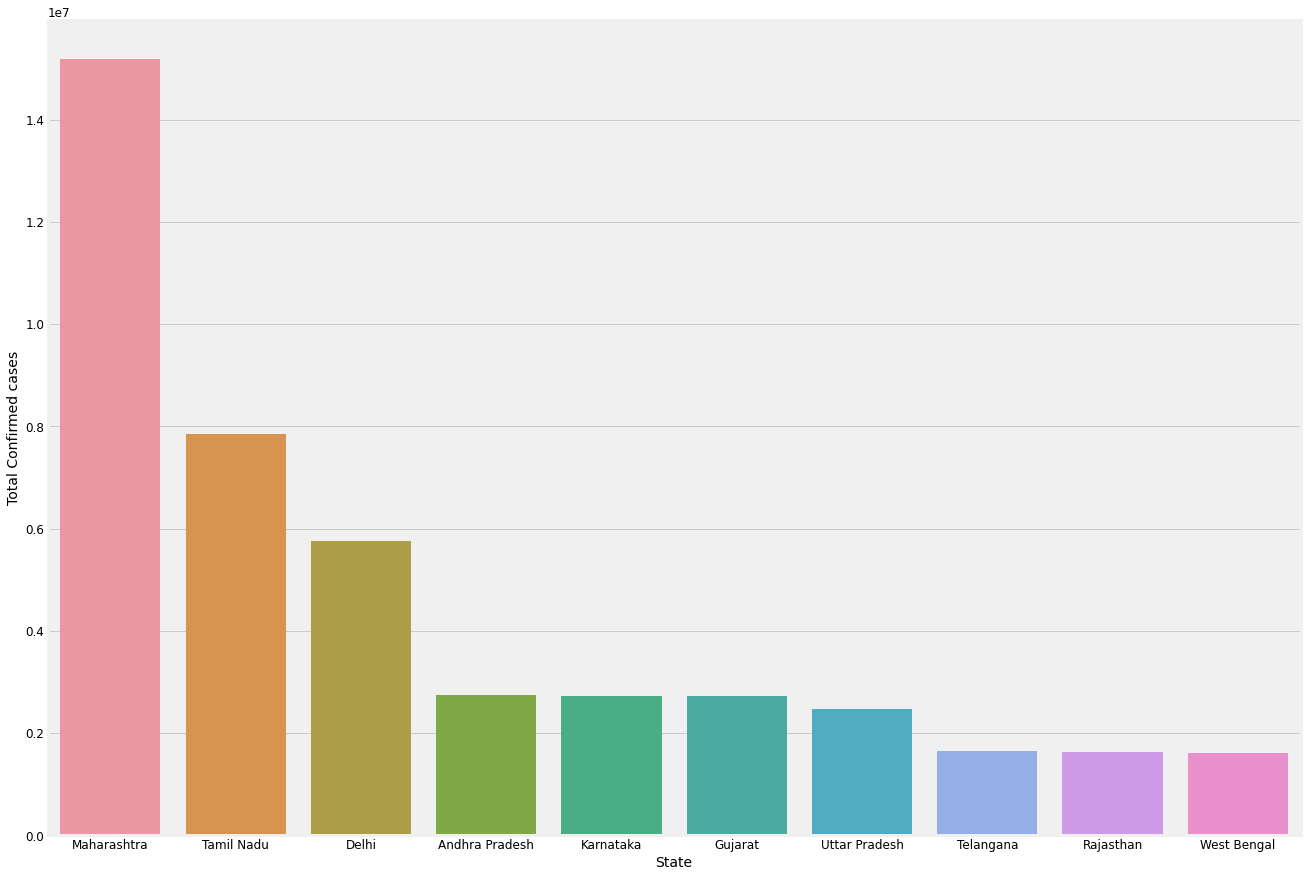

In [4]:
plt.figure(figsize=(20,15))
statewisedata=complete.groupby('State').sum()
statewisedata.reset_index(inplace=True)
statewisedata.sort_values(by='Total Confirmed cases',inplace=True,ascending=False)
sns.barplot(y='Total Confirmed cases',x='State',data=statewisedata.iloc[:10])
# # statewisedata.plot.bar(rot=0,figsize=(20,10))
# # statewisedata.plot.bar(rot=0,figsize=(20,10))

# plt.xticks(rotation=70)
# statewisedata.head()

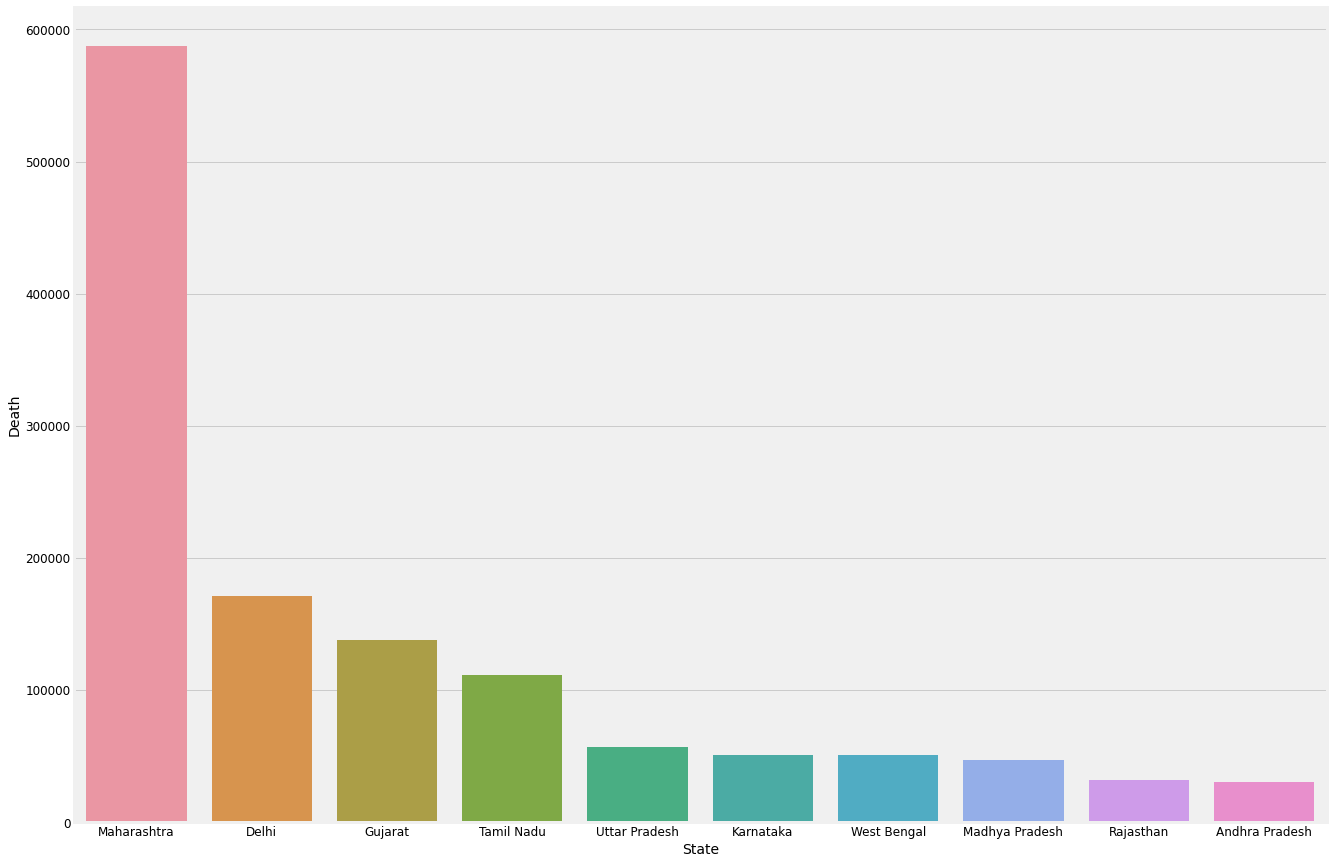

In [5]:
plt.figure(figsize=(20,15))
statewisedata=complete.groupby('State').sum()
statewisedata.reset_index(inplace=True)
statewisedata.sort_values(by='Death',inplace=True,ascending=False)
sns.barplot(y='Death',x='State',data=statewisedata.iloc[:10])

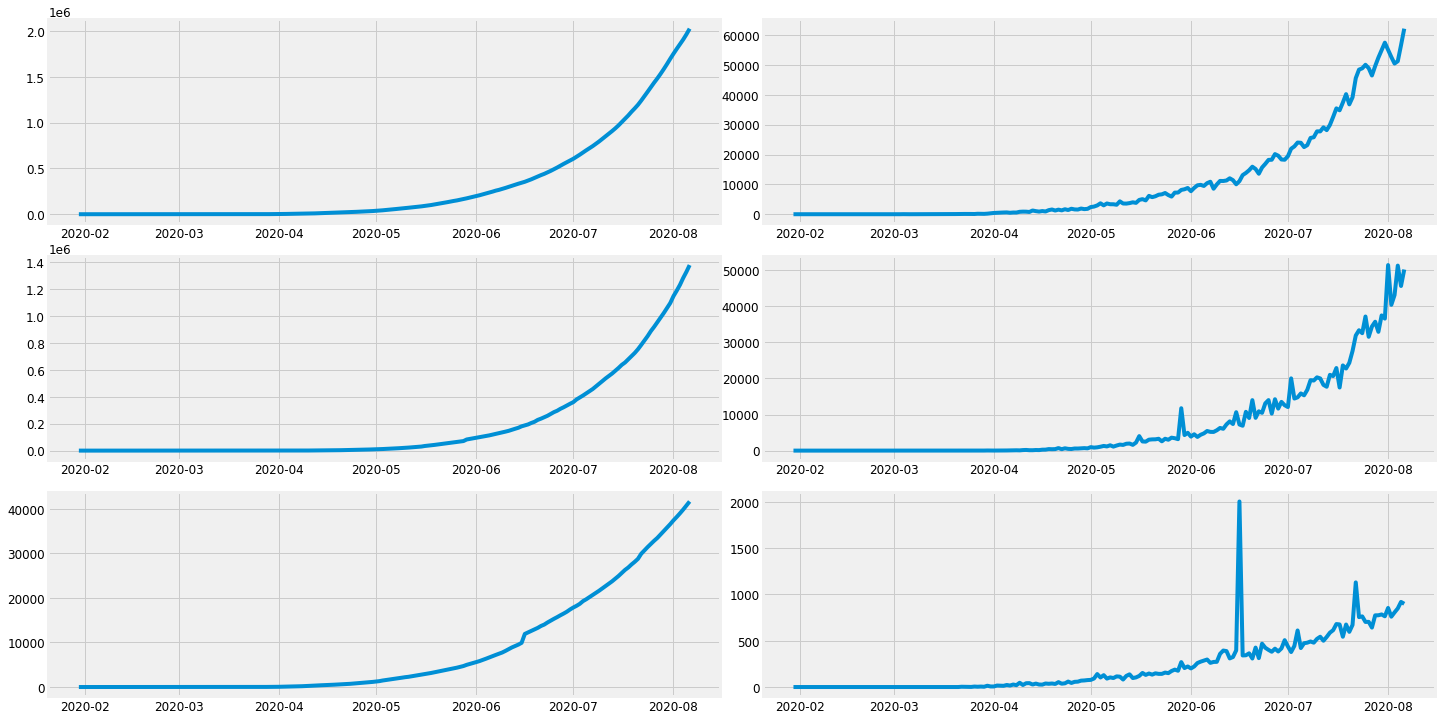

In [6]:
fig,ax=plt.subplots(3,2,figsize=(20,10))
fig.tight_layout()
ax[0,0].plot(indiadaily['Date'],indiadaily['Total Confirmed'])
ax[0,1].plot(indiadaily['Date'],indiadaily['Daily Confirmed'])
ax[1,0].plot(indiadaily['Date'],indiadaily['Total Recovered'])
ax[1,1].plot(indiadaily['Date'],indiadaily['Daily Recovered'])
ax[2,0].plot(indiadaily['Date'],indiadaily['Total Deceased'])
ax[2,1].plot(indiadaily['Date'],indiadaily['Daily Deceased'])

# plt.plot(indiadaily['Date'],indiadaily['Total Recovered'])
# plt.plot(indiadaily['Date'],indiadaily['Total Deceased'])

In [7]:
indiatesting=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_day_wise.csv')
indiatesting=indiatesting[['Tested As Of','Total Samples Tested']]
indiatesting['Tested As Of']=indiatesting['Tested As Of'].str.replace('/','-')
indiatesting.rename(columns={'Tested As Of':'Date'},inplace=True)
indiatesting.dropna(how='any',axis=0,inplace=True)
indiatesting.isnull().sum()
indiatesting['Date']= indiatesting['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d-%m-%Y'))
indiatesting['Date']= pd.to_datetime(indiatesting['Date'])
indiatesting.head()

,Date,Total Samples Tested
0,2020-03-13,6500.0
1,2020-03-18,13125.0
2,2020-03-19,13316.0
3,2020-03-19,14175.0
4,2020-03-20,14376.0


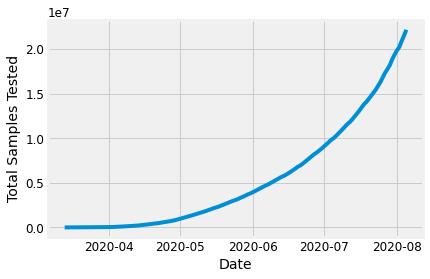

In [8]:
sns.lineplot(x='Date',y='Total Samples Tested',data=indiatesting)

# US COVID Data

In [9]:
usdaily=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/OtherDatasets/us.csv')
usdaily.rename(columns={'date':'Date'},inplace=True)
# indiadaily['Date'] = indiadaily['Date'].str.slice(0,6) +' 2020'
# indiadaily['Date']= indiadaily['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d %b %Y'))
usdaily['Date']= pd.to_datetime(usdaily['Date'])
print(usdaily.dtypes)
usdaily.tail()

Date      datetime64[ns]
cases              int64
deaths             int64
dtype: object


,Date,cases,deaths
257,2020-10-04,7444705,209606
258,2020-10-05,7487064,210035
259,2020-10-06,7529682,210756
260,2020-10-07,7582317,211750
261,2020-10-08,7638454,212678


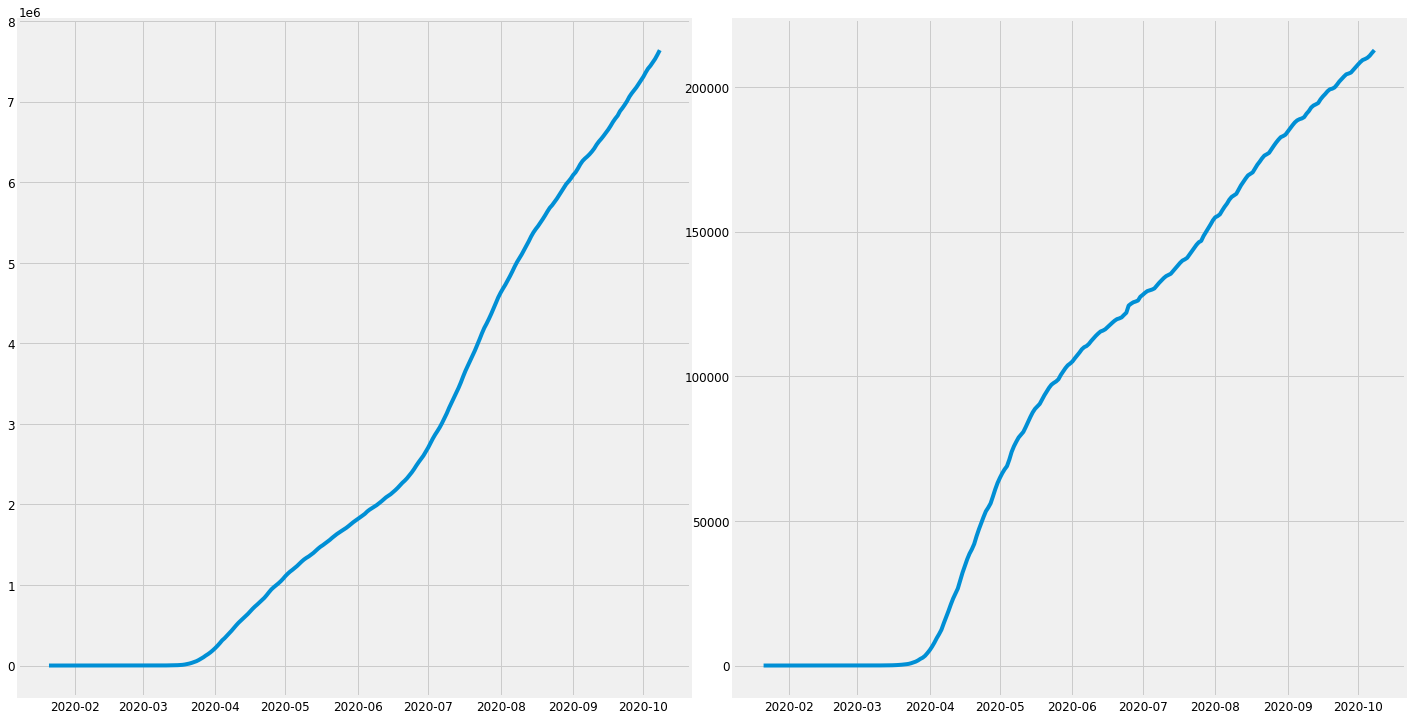

In [10]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
fig.tight_layout()
ax[0].plot(usdaily['Date'],usdaily['cases'])
ax[1].plot(usdaily['Date'],usdaily['deaths'])

# Merge India testing data with cases data 

In [13]:
indiacovidfinal = indiadaily.merge(indiatesting,how='inner',on='Date')
indiacovidfinal.tail()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,Total Samples Tested
141,2020-08-01,55117,1752185,51368,1146906,854,37420,19821831.0
142,2020-08-02,52672,1804857,40355,1187261,760,38180,20202858.0
143,2020-08-03,50488,1855345,43070,1230331,806,38986,20864750.0
144,2020-08-04,51282,1906627,51220,1281551,849,39835,21484402.0
145,2020-08-05,56626,1963253,45583,1327134,919,40754,22149351.0
